## AB Tests

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

import warnings
warnings.filterwarnings('ignore')

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [ ]:
data1 = pd.read_csv('dataset_part1_students.csv', sep = '\t')
data1.head(2)

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736


In [ ]:
data1.describe()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.075323,0.522300,0.501970,0.496674,0.501623,0.501036,0.497661,0.501234,0.497832,0.496958,0.499980,0.498894
std,3.035037,0.499515,0.288250,0.289476,0.289892,0.288132,0.288567,0.288967,0.287840,0.288291,0.288345,0.287987
min,-9.047982,0.000000,0.000159,0.000013,0.000057,0.000028,0.000004,0.000073,0.000110,0.000057,0.000012,0.000013
25%,0.026237,0.000000,0.251363,0.244871,0.251427,0.250494,0.250537,0.250726,0.249500,0.247673,0.251035,0.250138
50%,2.075935,1.000000,0.503203,0.496624,0.504957,0.498941,0.498581,0.499502,0.499507,0.492757,0.499955,0.500853
75%,4.140186,1.000000,0.751609,0.745780,0.753342,0.752575,0.746653,0.752015,0.744436,0.746960,0.748775,0.745164
max,13.895502,1.000000,0.999966,0.999936,0.999960,0.999987,0.999948,0.999885,0.999970,0.999913,0.999906,0.999982


In [ ]:
data1.W.unique()

array([0., 1.])

**1 задача**. Проверять будем через критерий Стьюдента, тк истинные значения дисперсий мы не знаем. В качестве нулевой гипотезы у нас равенство средних двух выборок, есть двухстороняя альтернатива(среднее больше или меньше).

In [ ]:
stats.ttest_ind(data1[data1.W == 0].y.values, 
                data1[data1.W == 1].y.values)

Ttest_indResult(statistic=-9.332400850259313, pvalue=1.1400916649505329e-20)

In [ ]:
ser = np.zeros(10)
for i in range(2, 12):
  ser[i-2] = stats.ttest_ind(data1[data1.W == 0].iloc[:,i].values, 
                                data1[data1.W == 1].iloc[:,i].values).pvalue
ser

array([0.        , 0.        , 0.05853151, 0.41427358, 0.92892563,
       0.52967332, 0.67738298, 0.8871715 , 0.76537788, 0.79707183])

Выводы:
* С уверенностью(уровень значимости при проверке гипотезы о равенстве средних = 1.14е-20 << 0.05) можем сказать, что на целевой выборке *у* средние в разных группах не равны.
* Оказалось, что на уровне значимости 0.95 мы можем отвернуть гипотезы о равенстве средних у выборок *Х_1, Х_2* из 10 указанных признаков *(уровень значимости у выборки **Х_3** оказался чуть выше 0.5, про него возможно сказать, что средние там отличаются)* после воздействия, на остальных выборках гипотезу о равенстве средних у групп отвергнуть нельзя.

**2-3 задача**. Эффект воздействия. 

Для начала, чтобы определить независимо ли распределение объектов от treatment, необходимо проверить гипотезу о равенстве распределений. Воспользуемся критерием согласия Хи-квадрат.

In [ ]:
# критерий Хи-квадрат
a = -11
b = 16
n = 12

ar_1 = np.zeros(n)
ar_0 = np.zeros(n)
for i in range(n):
  left_bound, right_bound = a + i*(b-a)/n, a + (i+1)*(b-a)/n
  ar_1[i] = np.where((data1[data1.W == 1].y > left_bound) & 
                     (data1[data1.W == 1].y < right_bound), 1, 0).sum()/data1[data1.W == 1].y.shape[0]
  ar_0[i] = np.where((data1[data1.W == 0].y > left_bound) & 
                     (data1[data1.W == 0].y < right_bound), 1, 0).sum()/data1[data1.W == 0].y.shape[0]

stats.chisquare(ar_1, ar_0)

Power_divergenceResult(statistic=0.020223553900870318, pvalue=0.9999999999999634)

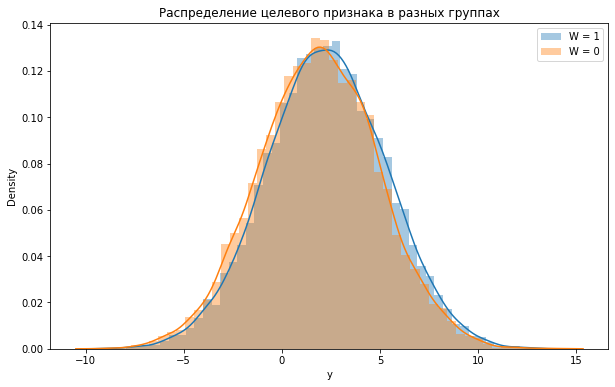

In [ ]:
plt.figure(figsize = (10, 6))
sns.distplot(data1[data1.W == 1].y, label = 'W = 1')
sns.distplot(data1[data1.W == 0].y, label = 'W = 0')
plt.title('Распределение целевого признака в разных группах')
plt.legend()
plt.show()

Сюдя по критериям (p-value < 0.(9) ) мы не можем отвергнуть гипотезу о несогласованности выборок, а сюдя по графику и по большому р-значению, мы вообще можем предположить, что эксперимент рандофицирован. Посмотрим на другие признаки.

In [ ]:
# для фичей
ser = np.zeros(10)
for j in range(2, 12):

  a = 0
  b = 1
  n = 11

  ar_1 = np.zeros(n)
  ar_0 = np.zeros(n)
  for i in range(n):
    left_bound, right_bound = a + i*(b-a)/n, a + (i+1)*(b-a)/n
    ar_1[i] = np.where((data1[data1.W == 1].iloc[:, j] > left_bound) & 
                      (data1[data1.W == 1].iloc[:, j] < right_bound), 1, 0).sum()/data1[data1.W == 1].iloc[:, j].shape[0]
    ar_0[i] = np.where((data1[data1.W == 0].iloc[:, j] > left_bound) & 
                      (data1[data1.W == 0].iloc[:, j] < right_bound), 1, 0).sum()/data1[data1.W == 0].iloc[:, j].shape[0]

  ser[j-2] = round(stats.chisquare(ar_0, ar_1).pvalue, 10)

print('Уровни значимости нулевой гипотезы критерия Хи-квадрат в выборках-признаках:')
ser

Уровни значимости нулевой гипотезы критерия Хи-квадрат в выборках-признаках:


array([0.99905318, 0.99907317, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Как видно у всеx признаков гипотезу о согласованности нельзя отвергать, это говорит в сторону предположения о рандомизированности эксперимента. Оценим АТЕ через модель линейной регресии.

In [ ]:
data1['bias'] = np.ones(data1.shape[0])
data1.head()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,bias
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700,1.0
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736,1.0
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049,1.0
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248,1.0
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656,1.0


In [ ]:
# воздействие на целевую переменную
lin_reg = LinearRegression()
lin_reg.fit(data1.drop('y', axis = 1), data1.y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lin_reg.coef_, lin_reg.score(data1.drop('y', axis = 1), data1.y)

(array([ 0.51338549, -0.2254694 , -0.35712379, -0.09795053,  0.93446704,
         0.42135781,  0.18572004,  0.08389393, -0.10409036, -0.11725869,
         0.04936036,  0.        ]), 0.015674224806845882)

In [ ]:
data1.drop('bias', axis = 1, inplace = True)

Нам нужен параметр возле признака *W*, он расположен первым в массиве и равен 0.513

Попробуем оценить АТЕ через разность средних по формуле $\sigma = E(Y_i|W_i = 1) - E(Y_i|W_i = 0)$, однако нам необходимо проверить еще пару предположений.

In [ ]:
data1[data1.W == 1].y.mean() - data1[data1.W == 0].y.mean()

0.4001031055444413

Text(0.5, 1.0, 'Распределение целевой переменной в разных классах')

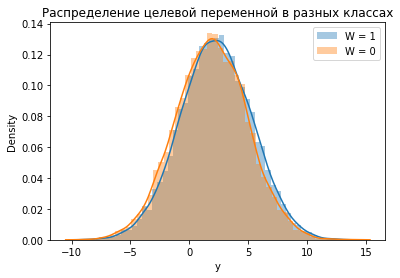

In [ ]:
sns.distplot(data1[data1.W == 1].y, label = 'W = 1')
sns.distplot(data1[data1.W == 0].y, label = 'W = 0')
plt.legend()
plt.title('Распределение целевой переменной в разных классах')

Надо проверить несмещенность этой оценки (selection bias). Однако исходя из преположений выше(относительно равномерного распределения по группам) можно предполагать, что распределение объектов в treatment и control группы не зависят от характеристик объектов(хактеристики = фичи, в данном случае). Из этого предположения следует и предполагать несмещенность оценки через разность средних.(P.S. однако, как заметно, некоторое смещение есть, оно равно ~ 0.1)

**4-5 задача**. Результаты и выводы

* Для первого пункта все расписано. Кратко, для целевой переменной и для первых двух признаков можно отклонить гипотезу о равенсте средних(третий признак под подозрением, там p-value ~ 0.05)
* С помощью критерия Хи-квадрат можно предположить, что экперимент рандомизирован. При оценки АТЕ через регрессию получили значение 0.513, а через разность средних целевой переменной по группам - значение 0.4 (является смещенной оценкой).
* Касаемо целевой переменной, после воздействия есть значимые различия в распределении классов(Хотя все еще неясно, были ли отличия между этими группами до воздейтсвия)

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

In [ ]:
data2 = pd.read_csv('dataset_part2_students.csv', sep = '\t')
data2.head(3)

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056


In [ ]:
list_feats = list(data2.drop('W', axis = 1).columns)

In [ ]:
data2[data2.W == 1][list_feats[1]]

0       2.785060
2       0.095546
3       3.590472
8       3.985938
9       2.688234
          ...   
9994   -0.615888
9995    1.207956
9996    1.636214
9998    0.777716
9999   -3.467385
Name: y_0, Length: 5240, dtype: float64

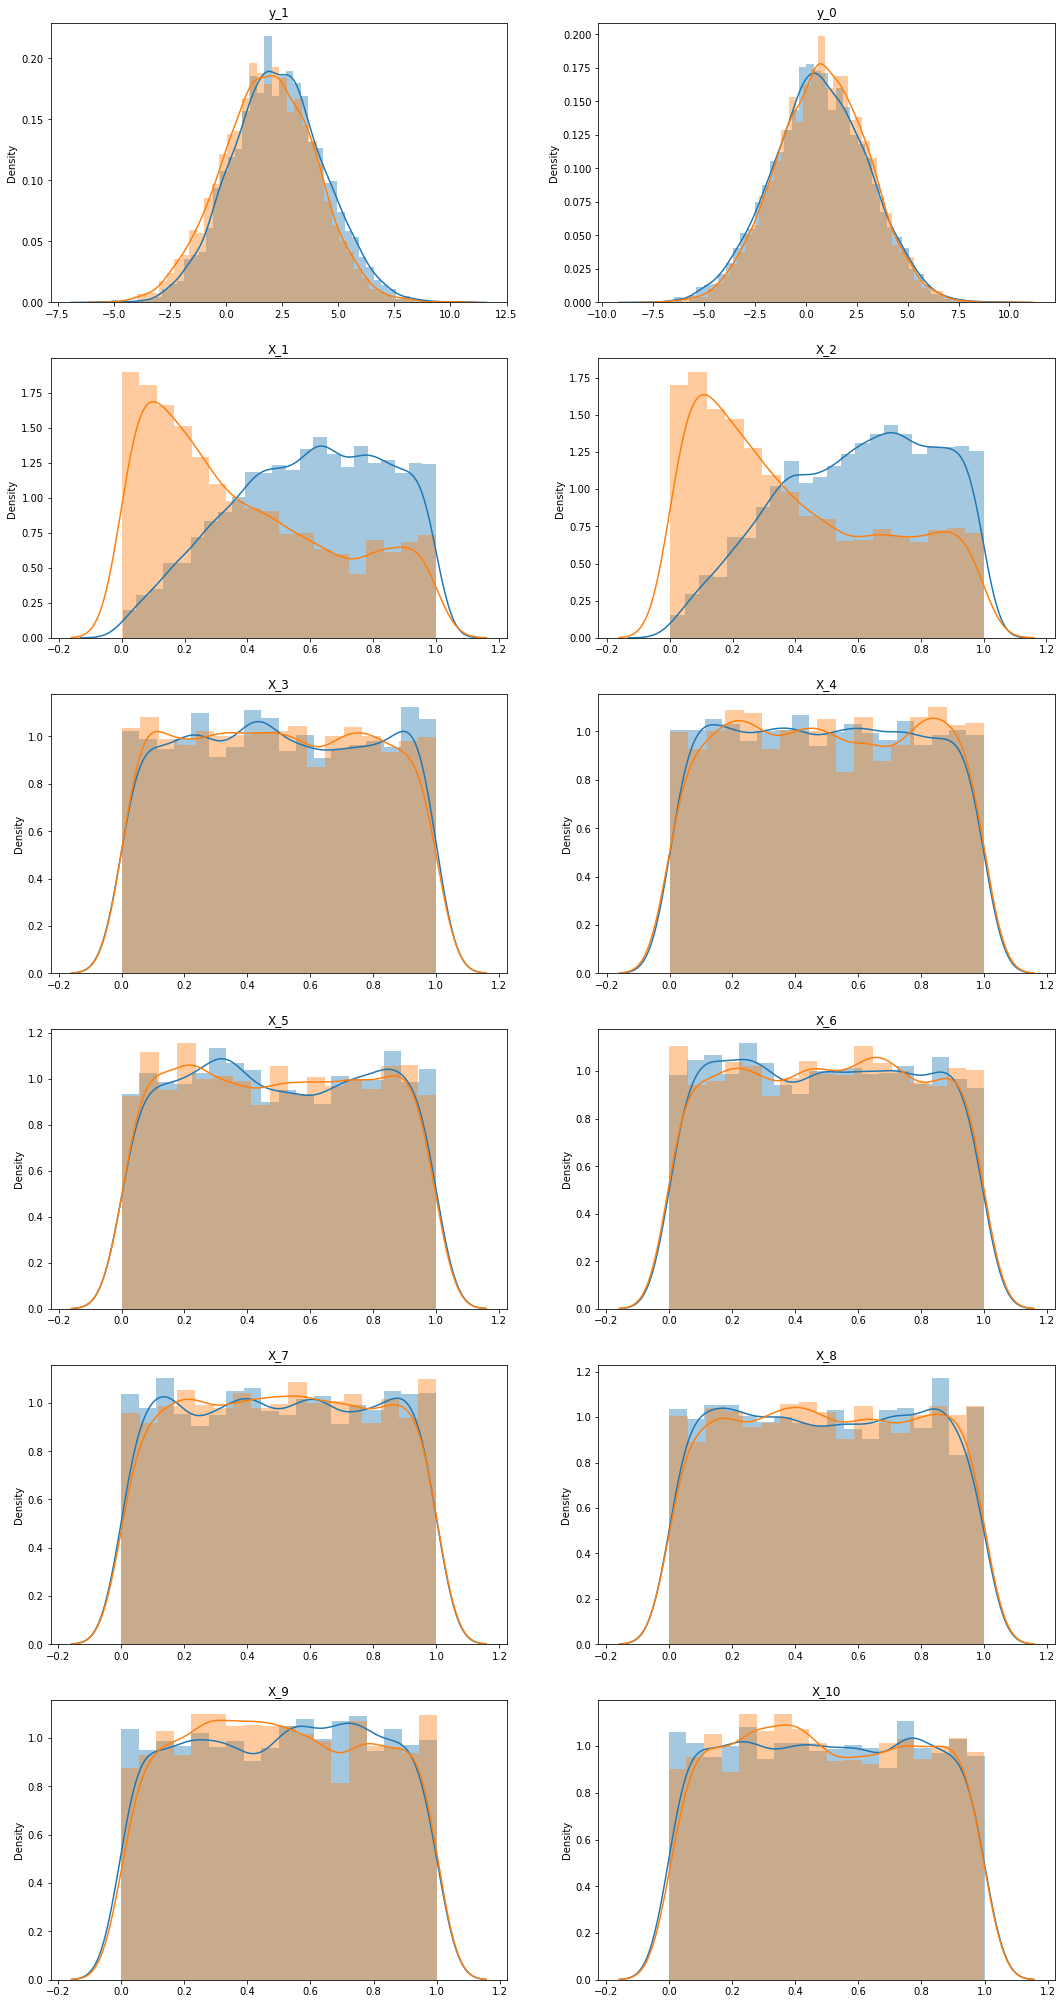

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(6, 2, figsize = (18, 36))
for i in range(len(list_feats)):
  plt.figure(figsize = (10, 6))
  sns.distplot(data2[data2.W == 1][list_feats[i]].values, label = 'W = 1', ax = ax[i//2, i%2])
  sns.distplot(data2[data2.W == 0][list_feats[i]].values, label = 'W = 0', ax = ax[i//2, i%2])
  ax[i//2, i%2].set_title(list_feats[i])

На графиках распределений значимые отличия видны только  в первых двух признаках.

**1 задача**. Проверка гипотез. 

Проверять снова будем равенство средних по Стьюденту, а также однородность выборок в разных классах через Хи-квадрат. 

Но прежде всего проверим выборки до и после воздействия на однородность.

In [ ]:
a = -5
b = 10
n = 11

ar_1 = np.zeros(n)
ar_0 = np.zeros(n)
for i in range(n):
  left_bound, right_bound = a + i*(b-a)/n, a + (i+1)*(b-a)/n
  ar_1[i] = np.where((data2['y_0'] > left_bound) & 
                    (data2['y_0'] < right_bound), 1, 0).sum()/data2['y_0'].shape[0]
  ar_0[i] = np.where((data2['y_1'] > left_bound) & 
                    (data2['y_1'] < right_bound), 1, 0).sum()/data2['y_1'].shape[0]

print('Уровни значимости нулевой гипотезы критерия Хи-квадрат:')
stats.chisquare(ar_0, ar_1)

Уровни значимости нулевой гипотезы критерия Хи-квадрат:


Power_divergenceResult(statistic=0.34791082328240763, pvalue=0.9999988513610073)

Гипотезу об однородности выборок отвергнуть пока нельзя.

In [ ]:
# равенство средних в разных классах по стьюденту во всех признаках 
ser = {}
for i in list_feats:
  ser[i] = stats.ttest_ind(data2[data2.W == 0][i].values, 
                                data2[data2.W == 1][i].values)
ser

{'X_1': Ttest_indResult(statistic=-38.08914057305451, pvalue=1.5073414961315105e-296),
 'X_10': Ttest_indResult(statistic=0.19856726275287878, pvalue=0.8426053015622622),
 'X_2': Ttest_indResult(statistic=-36.327132513102676, pvalue=1.6013109351613642e-271),
 'X_3': Ttest_indResult(statistic=-1.1388882181764262, pvalue=0.2547770672996611),
 'X_4': Ttest_indResult(statistic=0.819423988390126, pvalue=0.41256408565418534),
 'X_5': Ttest_indResult(statistic=-0.6969420909932433, pvalue=0.4858552389595523),
 'X_6': Ttest_indResult(statistic=0.714019273818174, pvalue=0.4752319296070401),
 'X_7': Ttest_indResult(statistic=0.5272606528423389, pvalue=0.5980242933251709),
 'X_8': Ttest_indResult(statistic=0.9836302299851056, pvalue=0.32532115789451477),
 'X_9': Ttest_indResult(statistic=-0.4039182722210444, pvalue=0.6862814582307828),
 'y_0': Ttest_indResult(statistic=2.6947405425339337, pvalue=0.007056118548053932),
 'y_1': Ttest_indResult(statistic=-10.434076818229196, pvalue=2.3383131389683154

Те самые два признака, выделяющиеся на графиках своим распределением в классах, выделяются своей огромной отрицательной степенью, что ожидаемо. На уровне значимости в 0.95 можно также отклонить гипотезу о равенстве и в двух целевых признаках.

In [ ]:
# для фичей и целевых признаков
ser = {}
for j in list_feats:

  if j == 'y_0' or j == 'y_1':
    a = -5
    b = 10
  else:
    a = 0
    b = 1
  
  n = 6

  ar_1 = np.zeros(n)
  ar_0 = np.zeros(n)
  for i in range(n):
    left_bound, right_bound = a + i*(b-a)/n, a + (i+1)*(b-a)/n
    ar_1[i] = np.where((data2[data2.W == 1][j] > left_bound) & 
                      (data2[data2.W == 1][j] < right_bound), 1, 0).sum()/data2[data2.W == 1][j].shape[0]
    ar_0[i] = np.where((data2[data2.W == 0][j] > left_bound) & 
                      (data2[data2.W == 0][j] < right_bound), 1, 0).sum()/data2[data2.W == 0][j].shape[0]

  ser[j] = stats.chisquare(ar_0, ar_1)
print('Уровни значимости нулевой гипотезы критерия Хи-квадрат:')
ser

Уровни значимости нулевой гипотезы критерия Хи-квадрат:


{'X_1': Power_divergenceResult(statistic=1.3824563829619958, pvalue=0.9262226937642687),
 'X_10': Power_divergenceResult(statistic=0.0018598955921136189, pvalue=0.9999999920698438),
 'X_2': Power_divergenceResult(statistic=1.2843207071298548, pvalue=0.9365367668859078),
 'X_3': Power_divergenceResult(statistic=0.002583267278624562, pvalue=0.9999999819751567),
 'X_4': Power_divergenceResult(statistic=0.0011455257140500737, pvalue=0.9999999976385257),
 'X_5': Power_divergenceResult(statistic=0.0010209210919022436, pvalue=0.9999999982291944),
 'X_6': Power_divergenceResult(statistic=0.0007295194499884019, pvalue=0.9999999992355874),
 'X_7': Power_divergenceResult(statistic=0.0017049791453343883, pvalue=0.9999999936190985),
 'X_8': Power_divergenceResult(statistic=0.001492536519717493, pvalue=0.9999999954245931),
 'X_9': Power_divergenceResult(statistic=0.004092116922511513, pvalue=0.9999999431036743),
 'y_0': Power_divergenceResult(statistic=0.0058284555502015065, pvalue=0.999999862333400

Рассматривая уровни значимости всех признаков, нигде нельзя отвергнуть гипотезу о несогласованности выборок($H_0$), то есть снова можно предположить, что эксперимент рандомизирован. Это видно и на графиках распределений(для признаков *X_1, X_2*, у которых на графиках видны значимые разлличия в распределениях классов статистика больше, чем в других признках вследствие чего наблюдается снижение уровня значимости нулевой гипотезы)

**2 задача**. Оценки АТЕ

$ATE = E[Y_i(1)|W_i = 1] - E[Y_i(0)|W_i = 0]$, где $Y_i(W_i) = y_{i,1} - y_{i,0}$, так как было предположено, что эксперимент рандомизирован(может являться смещенной оценкой).

In [ ]:
data2['y_diff'] = data2.y_1 - data2.y_0
data2[data2.W == 1]['y_diff'].mean() - data2[data2.W == 0]['y_diff'].mean()

0.5549047702971162

Через модель регрессии: $ATE = \tau$, где $Y_i = \alpha_i + \tau W_i$; $\alpha_i = Y_{i,0}$

In [ ]:
data2['bias'] = np.ones(data2.shape[0])
data2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,y_diff,bias
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310,3.102097,1.0
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161,-3.300914,1.0
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056,0.048874,1.0
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770,-6.036897,1.0
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209,0.797684,1.0


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(data2.drop(['y_0', 'y_1', 'y_diff'], axis = 1), data2['y_diff'])

lin_reg.coef_, lin_reg.score(data2.drop(['y_0', 'y_1', 'y_diff'], axis = 1), data2['y_diff'])

(array([ 0.54250715,  0.08350872, -0.02728065,  0.29757501,  0.0447983 ,
         0.1117733 ,  0.09828827,  0.0718624 ,  0.15933881, -0.06269531,
        -0.08583998,  0.        ]), 0.009684251774472963)

Из данного массива нам потребуется лишь первый коэффициент, он равен 0.543

In [ ]:
data2.drop('bias', axis=1, inplace = True)

ANCOVA ATE

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(data2.drop(['y_1', 'y_diff'], axis = 1), data2['y_1'])

lin_reg.coef_, lin_reg.score(data2.drop(['y_1', 'y_diff'], axis = 1), data2['y_1'])

(array([ 0.0025517 ,  0.54817902, -0.26361705, -0.29451817, -0.13828213,
         0.97884494,  0.62914046,  0.07872574,  0.20004789,  0.11316678,
        -0.04212069, -0.02273621,  0.        ]), 0.041673162345950754)

Отсюда нужен второй элемент из массива, это коэффициент при $W_i$, он равен 0.548

**3 задача** Анализ полученных значений.

* Из оценки с помощью регресии получено значение АТЕ = 0.542
* Из оценки АТЕ по формуле для рандомизированного эксперимента АТЕ = 0.555
* Из оценки по ANCOVA ATE = 0.548

Эти значения довольно близки, каждое из них может свидетельствовать о разнице в различных классах после воздействия на группы.  

**4 задача**. Итоги

* Графики

На графиках распределения переменных в разных группах видны значимые отличия только в признаках *Х_1, Х_2*, про другие признаки по графикам особых закономерностей не видно.

* Критерии

По критериям Хи-квадрат можно утверждать, что отклонять гипотезу о том, что выборки как-то отличаются в разных никак нельзя(p-valuе ~ 1), логично преждположить, что эксперимент рандомизирован. Также, судя по критериям Стьюдента, можно отклонить гипотезу о равенстве средних распределений разных классов в целевых переменных *у_0, у_1*.

* АТЕ

Подситав АТЕ разными способами(что первый, что второй методы дали примерно одинаковое значение), было получено число значимо отличное от нуля. Можно предпоплагать, что воздействие на целевой признак дало эффект.

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [ ]:
data3 = pd.read_csv('dataset_part3_students.csv', sep = '\t')
data3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


In [ ]:
data3[['treatment', 'conversion']]

,treatment,conversion
0,control,0
1,control,0
2,control,0
3,treatment,1
4,control,0
...,...,...
199995,control,0
199996,control,0
199997,control,0
199998,treatment,0


**1 пункт** Оценка АТЕ

In [ ]:
# ANCOVA
data3['W'] = (data3['treatment'] == 'treatment')

lin_mod = LinearRegression()

lin_mod.fit(data3.drop(['treatment', 'conversion'], axis = 1), data3['conversion'])

pd.Series(index = data3.drop(['treatment', 'conversion'], axis = 1).columns, data = lin_mod.coef_)['W']

0.06021320907166228

Как видно, здесь оценка АТЕ дала малое значение, что говорит о низком влиянии эффекта, через регрессию методом ANCOVA/

**2 пункт** Оценка САТЕ

In [ ]:
# S-learner Log-regression

log = LogisticRegression()

log.fit(data3.drop(['treatment', 'conversion'], axis = 1), data3['conversion'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = log.predict(data3.drop(['treatment', 'conversion'], axis = 1))

In [ ]:
data3['W_reverse'] = 1 - data3['W']
preds_reverse = log.predict(data3.drop(['treatment', 'W', 'conversion'], axis = 1))

In [ ]:
data3['CATE'] = abs(preds - preds_reverse)

In [ ]:
data3['CATE'].describe()

count    200000.000000
mean          0.050255
std           0.218471
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: CATE, dtype: float64

In [ ]:
data3.drop(['W_reverse'], axis = 1, inplace = True)
data3[data3['CATE'] > 0]

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,W,CATE
61,treatment,-0.610373,-0.308647,-0.237840,0.120394,1.052224,-0.317636,1.246088,0.919782,0.120394,0.047684,0.325346,-0.473962,1.331890,1.226932,0.211140,0.488760,0.985664,-0.930406,-0.791488,-2.744115,-0.422957,-1.238070,0,True,1
64,treatment,0.225266,1.866995,-1.810772,2.313687,1.499071,-0.520162,-0.047561,0.666013,2.313687,0.438317,0.021688,0.330910,1.267161,0.654121,0.170246,-0.586087,2.144802,-0.328851,-0.038509,-1.618549,0.526942,0.119248,1,True,1
71,treatment,-1.589058,1.600086,-0.102487,-0.203783,2.280610,-3.553484,0.112979,1.485081,-0.203783,0.370620,1.402116,-1.173238,-0.055089,0.436930,-0.007728,2.092004,0.372389,2.456058,2.185219,-0.733725,1.195737,-0.311258,0,True,1
96,treatment,0.531269,2.586262,1.147006,2.681065,1.169534,-0.375777,1.354496,0.840933,2.681065,-0.883640,1.531179,1.058642,1.037474,1.479558,0.506364,0.884710,1.266842,1.455592,1.495042,-1.359134,0.801101,-1.256396,1,True,1
120,control,-1.469638,2.336132,0.450287,0.341199,2.829890,-4.002050,-0.582505,0.725294,0.341199,-1.952663,-0.129815,-1.181808,-0.270466,0.473038,0.646938,3.217458,-0.726883,2.902371,2.636675,-1.706852,0.290161,-1.074301,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199864,control,-0.806263,1.255607,-0.978384,1.659797,2.986155,-1.770437,-0.769514,1.717997,1.659797,0.764483,-0.735556,1.259265,-1.634714,0.004427,-0.839384,0.947836,1.052869,0.596977,0.636952,-0.366053,1.389036,0.316250,0,False,1
199880,treatment,-1.714522,2.606462,-0.929439,-1.944212,2.456356,-5.406497,0.473810,-0.913330,-1.944212,0.640774,0.897207,1.396955,-0.390451,0.505808,-0.379954,-1.246878,-0.869221,-0.818538,-0.344976,-0.170926,1.701051,0.387997,1,True,1
199890,control,-0.443619,2.556140,-0.376256,0.072080,1.826305,-3.030125,-0.289345,0.908622,0.072080,0.434511,-0.417365,-0.099745,-1.395902,1.027294,-0.043141,-0.728158,-1.769034,-2.122948,-1.407942,-0.393922,1.440480,-0.003752,0,False,1
199933,treatment,0.146755,2.712056,0.133350,3.158502,2.530837,-0.629692,3.179561,0.595427,3.158502,0.520665,0.255114,-0.088595,1.140088,-1.319979,-0.160052,2.786912,-0.405274,2.336759,2.224314,-3.885938,-1.363210,-1.992318,1,True,1


In [ ]:
# T-learner
log_reg0 = LogisticRegression()
log_reg0.fit(data3[data3.W == 0].drop(['treatment', 'conversion', 'CATE'], axis = 1), data3[data3.W == 0]['conversion'])

preds0 = log_reg0.predict(data3.drop(['treatment', 'conversion', 'CATE'], axis = 1))

log_reg1 = LogisticRegression()
log_reg1.fit(data3[data3.W == 1].drop(['treatment', 'conversion', 'CATE'], axis = 1), data3[data3.W == 1]['conversion'])

preds1 = log_reg1.predict(data3.drop(['treatment', 'conversion', 'CATE'], axis = 1))

data3['CATE_T'] = preds1 - preds0

In [ ]:
data3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,W,CATE,CATE_T
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,False,0,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,False,0,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,False,0,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,True,0,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,False,0,0


In [ ]:
# X-learner
D1 = preds1 - data3['conversion']
D0 = data3['conversion'] - preds0


log_mod = LogisticRegression()
log_mod.fit(data3.drop(['treatment', 'conversion', 'CATE', 'CATE_T'], axis = 1), D1)
tau1 = log_mod.predict(data3.drop(['treatment', 'conversion', 'CATE', 'CATE_T'], axis = 1))
log_mod.fit(data3.drop(['treatment', 'conversion', 'CATE', 'CATE_T'], axis = 1), D0)
tau0 = log_mod.predict(data3.drop(['treatment', 'conversion', 'CATE', 'CATE_T'], axis = 1))

e = log.predict_proba(data3.drop(['treatment', 'conversion', 'CATE', 'CATE_T'], axis = 1))[:, 1]

In [ ]:
cate_X = e*tau0 + (1-e)*tau1

In [ ]:
data3['CATE_X']= cate_X

**3 пункт**. Рекомендации для обьектов

In [ ]:
dat = data3.iloc[:, -5:]

In [ ]:
dat['sum_cate'] = dat['CATE']+dat['CATE_T']+dat['CATE_X']

Рекомендуем товар или услугу, если 2 из 3 найденных коэффициентов САТЕ > 0 (=1)

In [ ]:
dat['recome'] = (dat['sum_cate'] > 1)

**4 пункт** Ожидаемая конверсия

In [ ]:
dat.conversion.mean()

0.152935

Значение конверсии довольно высокое.

**5 пункт** Выводы.

In [ ]:
# Доля рекомендаций ко всем объектам
dat.recome.mean()

0.062105

Если вспомним про оценку АТЕ из первого пункта, то она равна 0.0602, что примерно и соотвествует доле рекомендаций к всей выборке. СТоит отметить, что число рекомендаций значительно меньше количества всех объектов. Откуда можно предположить, что теперь признаки объектов влияют на распределение объектов в различных группах.